In [2]:
import numpy as np
import cudaq

**MTS:**

In [3]:
def Combine(p1, p2):
    n = len(p1)
    k = np.random.randint(1, n)
    return np.concatenate([p1[:k], p2[k:]])

def Mutate(seq, p_mut):
    seq = seq.copy()
    for i in range(len(seq)):
        if (np.random.random() < p_mut):
            seq[i] *= -1
    return seq

def flip(seq, i):
    s_new = seq.copy()
    s_new[i] *= -1
    return s_new

def energy(seq):
    # Compute E(S) = Σ C_k²
    E = 0
    n = len(seq)
    for k in range(1, n):
        C_k = np.sum(seq[:n-k] * seq[k:])
        E += C_k * C_k
    return E

    
def TabuSearch(seq, max_iter, min_tabu, max_tabu):
    n = len(seq)
    tabu_list = np.zeros(n)
    
    best_seq_ts = seq.copy()
    best_energy_ts = energy(best_seq_ts)
    
    # pivot ← seq
    pivot = seq.copy()
    pivot_energy = energy(pivot)
    
    for t in range(1, max_iter + 1):
        best_i = -1
        best_flip_energy = float('inf')
        best_candidates = []
        
        for i in range(n):
            if tabu_list[i] < t:
                flipped = flip(pivot, i)
                flip_energy = energy(flipped)
                
                if flip_energy < best_flip_energy:
                    best_flip_energy = flip_energy
                    best_candidates = [i]
                elif flip_energy == best_flip_energy:
                    # Randomly choose one if there are multiple
                    best_candidates.append(i)
                    
        if best_candidates:
            best_i = np.random.choice(best_candidates)
        else:
            # If all moves are tabu, pick the least recently tabu'd
            best_i = np.argmin(tabu_list)
            best_flip_energy = energy(flip(pivot, best_i))
        
        # pivot ← flip(pivot, i)
        pivot = flip(pivot, best_i)
        pivot_energy = best_flip_energy
        
        tabu_list[best_i] = t + np.random.randint(min_tabu, max_tabu + 1)
        
        if pivot_energy < best_energy_ts:
            best_seq_ts = pivot.copy()
            best_energy_ts = pivot_energy
    
    return best_seq_ts

    

def MTS(population, max_iterations):

    # stop the while!
    iteration = 0
    
    Kp = len(population)     
    Np = len(population[0])
    for i in range(Kp):
        population[i] = TabuSearch(population[i], int(max_iterations // Kp), 1, max(int(np.sqrt(Np)), 2))

    best_seq = population[0].copy()
    worst_seq = population[0].copy()
    worst_energy = energy(worst_seq)
    best_energy = energy(best_seq)
    for p in population:
        p_energy = energy(p)
        if p_energy < best_energy:
            best_seq = p.copy()
            best_energy = p_energy
        if p_energy > worst_energy:
            worst_energy_idx = p
            worst_energy = p_energy

    history = [(best_energy, 0)]
    
    while (best_energy > target_e and iteration < max_iterations):
        iteration += 1
        if (np.random.rand() < p_comb):
            p1_i = np.random.randint(0, Kp)
            p2_i = np.random.randint(0, Kp)
            child = Combine(population[p1_i], population[p2_i])
        else:
            child_i = np.random.randint(0, Kp)
            child = population[child_i].copy()
            
        child = Mutate(child, p_mut)
        child = TabuSearch(child, int(max_iterations // Kp), 1, max(int(np.sqrt(Np)), 2))
        child_energy = energy(child)
        if(best_energy > child_energy):
            best_seq = child.copy()
            best_energy = child_energy
        if(child_energy < worst_energy):
            random_idx = np.random.randint(0, Kp)
            population[random_idx] = child

        history.append((best_energy, iteration))
        
        # Progress
        if iteration % 50 == 0:
            print("iter", iteration,
              "best", best_energy,
              "child", child_energy)
    
    return best_seq, best_energy, history

**Pauli rotation building blocks:**

In [4]:
@cudaq.kernel
def RYZ(theta: float, q0: cudaq.qubit, q1: cudaq.qubit):
    # exp(-i theta/2 * Y ⊗ Z)
    rx(math.pi/2,  q0)
    rz(theta,   q0, q1)
    rx(-np.pi/2, q0)

@cudaq.kernel
def RZY(theta: float, q0: cudaq.qubit, q1: cudaq.qubit):
    # exp(-i theta/2 * Z ⊗ Y)
    rx(math.pi/2,  q1)
    rz(theta,   q0, q1)
    rx(-math.pi/2, q1)

@cudaq.kernel
def RZZZZ(theta: float, q0: cudaq.qubit, q1: cudaq.qubit, q2: cudaq.qubit, q3: cudaq.qubit):
    # exp(-i theta/2 * ZZZZ) parity-to-last trick
    cx(q0, q3)
    cx(q1, q3)
    cx(q2, q3)
    rz(theta, q3)
    cx(q2, q3)
    cx(q1, q3)
    cx(q0, q3)

@cudaq.kernel
def RYZZZ(theta: float, q0: cudaq.qubit, q1: cudaq.qubit, q2: cudaq.qubit, q3: cudaq.qubit):
    rx(math.pi/2,  q0)
    RZZZZ(theta, q0, q1, q2, q3)
    rx(-math.pi/2, q0)

@cudaq.kernel
def RZYZZ(theta: float, q0: cudaq.qubit, q1: cudaq.qubit, q2: cudaq.qubit, q3: cudaq.qubit):
    rx(math.pi/2,  q1)
    RZZZZ(theta, q0, q1, q2, q3)
    rx(-math.pi/2, q1)

@cudaq.kernel
def RZZYZ(theta: float, q0: cudaq.qubit, q1: cudaq.qubit, q2: cudaq.qubit, q3: cudaq.qubit):
    rx(math.pi/2,  q2)
    RZZZZ(theta, q0, q1, q2, q3)
    rx(-math.pi/2, q2)

@cudaq.kernel
def RZZZY(theta: float, q0: cudaq.qubit, q1: cudaq.qubit, q2: cudaq.qubit, q3: cudaq.qubit):
    rx(math.pi/2,  q3)
    RZZZZ(theta, q0, q1, q2, q3)
    rx(-math.pi/2, q3)

In [5]:
@cudaq.kernel
def qaoa_seed_kernel(
    N: int,
    G2_i: list[int], G2_j: list[int],     # length = M2
    G4_a: list[int], G4_b: list[int], G4_c: list[int], G4_d: list[int],  # length = M4
    gammas: list[float], betas: list[float],
    w2: list[float], w4: list[float]     
):
    q = cudaq.qvector(N)

    # |+>^N
    h(q)

    p = len(gammas)

    for layer in range(p):
        gamma = gammas[layer]
        beta  = betas[layer]

        for t in range(len(G2_i)):
            i = G2_i[t]
            j = G2_j[t]
            theta = 2.0 * gamma * w2[t]
            RYZ(theta, q[i], q[j])
            RZY(theta, q[i], q[j])

        for t in range(len(G4_a)):
            a = G4_a[t]; b = G4_b[t]; c = G4_c[t]; d = G4_d[t]
            theta = 2.0 * gamma * w4[t]
            RYZZZ(theta, q[a], q[b], q[c], q[d])
            RZYZZ(theta, q[a], q[b], q[c], q[d])
            RZZYZ(theta, q[a], q[b], q[c], q[d])
            RZZZY(theta, q[a], q[b], q[c], q[d])

        for qubit in q:
            rx(2.0 * beta, qubit)

In [6]:
def flatten_G2(G2):
    G2_i = [int(i) for (i, j) in G2]
    G2_j = [int(j) for (i, j) in G2]
    return G2_i, G2_j

def flatten_G4(G4):
    a = [int(x[0]) for x in G4]
    b = [int(x[1]) for x in G4]
    c = [int(x[2]) for x in G4]
    d = [int(x[3]) for x in G4]
    return a, b, c, d


**Get Interactions:**

In [7]:
def get_interactions(N):
    """
    Generates the interaction sets G2 and G4 based on the loop limits in Eq. 15.
    Returns standard 0-based indices as lists of lists of ints.
    
    Args:
        N (int): Sequence length.
        
    Returns:
        G2: List of lists containing two body term indices
        G4: List of lists containing four body term indices
    """
    
    G2 = [ ]
    G4 = [ ]

    for i in range(N-2):
        for k in range(1, (N-i) // 2):
            G2.append([i , i + k])

    for i in range(N-3):
        for t in range(1, (N-i-1) // 2):
            for k in range(t + 1 , N-i-t):
                G4.append([i , i + t , i + k , i + k + t])


    return G2, G4

In [8]:
def sample_result_to_mts_population(result: cudaq.SampleResult, N: int, K: int) -> np.ndarray:
    """
    QAOA result (With the lowest energy) -> MTS population
    """
    
    def bitstring_to_spin(b: str) -> np.ndarray:
        b = b.replace(" ", "").zfill(N)
        bits = b[-N:]
        return np.array([1 if ch == "1" else -1 for ch in bits], dtype=np.int8)
    
    solutions = []
    for bitstring in result:
        spin = bitstring_to_spin(bitstring)
        e = energy(spin)
        count = result.count(bitstring)
        solutions.append((spin, e, count))

    solutions.sort(key=lambda x: x[1])
    
    top_k = solutions[:K]
    population = np.array([s[0] for s in top_k], dtype=np.int8)
    
    print(f"N={N}, Top {K} by energy:")
    for spin, e, count in top_k:
        print(f"  Energy={e}, Count={count}")
    
    return population

In [9]:
N = 30
G2, G4 = get_interactions(N)
G2_i, G2_j = flatten_G2(G2)
G4_a, G4_b, G4_c, G4_d = flatten_G4(G4)

w2 = [1.0] * len(G2_i)
w4 = [1.0] * len(G4_a)

gammas = [0.8]
betas  = [0.4]

shots = 2048
result = cudaq.sample(
    qaoa_seed_kernel,
    N, G2_i, G2_j, G4_a, G4_b, G4_c, G4_d,
    gammas, betas,
    w2, w4,
    shots_count=shots
)

target_e = 20
p_comb = 0.7
p_mut = 1/N
K = 50

quantum_pop = sample_result_to_mts_population(result, N=N, K=K)

# random baseline
random_pop = np.random.choice([-1, 1], size=(K, N))

IOStream.flush timed out


N=30, Top 50 by energy:
  Energy=115, Count=1
  Energy=131, Count=1
  Energy=147, Count=1
  Energy=155, Count=1
  Energy=155, Count=1
  Energy=155, Count=1
  Energy=163, Count=1
  Energy=163, Count=1
  Energy=163, Count=1
  Energy=171, Count=1
  Energy=171, Count=1
  Energy=171, Count=1
  Energy=171, Count=1
  Energy=171, Count=1
  Energy=179, Count=1
  Energy=179, Count=1
  Energy=179, Count=1
  Energy=179, Count=1
  Energy=179, Count=1
  Energy=179, Count=1
  Energy=179, Count=1
  Energy=179, Count=1
  Energy=187, Count=1
  Energy=187, Count=1
  Energy=187, Count=1
  Energy=187, Count=1
  Energy=187, Count=1
  Energy=187, Count=1
  Energy=187, Count=1
  Energy=187, Count=1
  Energy=187, Count=1
  Energy=195, Count=1
  Energy=195, Count=1
  Energy=195, Count=1
  Energy=195, Count=1
  Energy=195, Count=1
  Energy=195, Count=1
  Energy=195, Count=1
  Energy=195, Count=1
  Energy=203, Count=1
  Energy=203, Count=1
  Energy=203, Count=1
  Energy=203, Count=1
  Energy=203, Count=1
  Energy

In [10]:
best_q_seq, best_q_energy, hist_q = MTS(quantum_pop.copy(), 1000)
best_r_seq, best_r_energy, hist_r = MTS(random_pop.copy(), 1000)


print("QAOA-seeded best energy:", best_q_energy, "QAOA-seeded best sequence:", best_q_seq)
print("Random-seeded best energy:", best_r_energy, "Random-seeded best sequence:", best_r_seq)

iter 50 best 75 child 83
iter 100 best 75 child 115
iter 150 best 75 child 99
iter 200 best 75 child 99
iter 250 best 75 child 123
iter 300 best 75 child 115
iter 350 best 75 child 107
iter 400 best 75 child 75
iter 450 best 59 child 99
iter 500 best 59 child 99
iter 550 best 59 child 91
iter 600 best 59 child 91
iter 650 best 59 child 115
iter 700 best 59 child 83
iter 750 best 59 child 115
iter 800 best 59 child 91
iter 850 best 59 child 107
iter 900 best 59 child 107
iter 950 best 59 child 115
iter 1000 best 59 child 83
iter 50 best 75 child 83
iter 100 best 75 child 83
iter 150 best 75 child 107
iter 200 best 75 child 115
iter 250 best 75 child 99
iter 300 best 75 child 115
iter 350 best 75 child 107
iter 400 best 75 child 107
iter 450 best 67 child 91
iter 500 best 67 child 99
iter 550 best 67 child 91
iter 600 best 67 child 107
iter 650 best 67 child 115
iter 700 best 67 child 91
iter 750 best 67 child 107
iter 800 best 67 child 83
iter 850 best 67 child 107
iter 900 best 67 chil

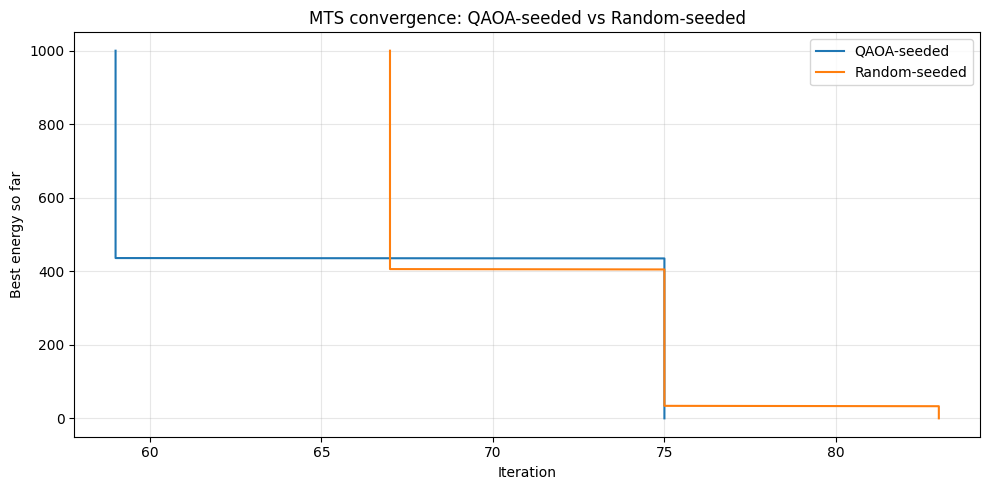

Final best energies -> QAOA: 59 | Random: 67


In [11]:
import matplotlib.pyplot as plt

def unpack_history(hist):
    """
    Supports:
      - [e0, e1, e2, ...]  (energies only)
      - [(e0, it0), (e1, it1), ...]  (energy, iteration)
      - [(it0, e0), (it1, e1), ...]  (iteration, energy)  -> auto-detected
    Returns: (xs, ys) as numpy arrays
    """
    if len(hist) == 0:
        return np.array([]), np.array([])

    first = hist[0]

    # energies only
    if isinstance(first, (int, float, np.floating, np.integer)):
        ys = np.asarray(hist, dtype=float)
        xs = np.arange(len(ys))
        return xs, ys

    # tuple/list pairs
    a, b = first
    # Heuristic: iteration is usually an int and non-decreasing
    if isinstance(b, (int, np.integer)) and not isinstance(a, (int, np.integer)):
        # (energy, iter)
        ys = np.asarray([p[0] for p in hist], dtype=float)
        xs = np.asarray([p[1] for p in hist], dtype=int)
        return xs, ys
    else:
        # assume (iter, energy)
        xs = np.asarray([p[0] for p in hist], dtype=int)
        ys = np.asarray([p[1] for p in hist], dtype=float)
        return xs, ys

xq, yq = unpack_history(hist_q)
xr, yr = unpack_history(hist_r)

plt.figure(figsize=(10, 5))
plt.plot(xq, yq, label="QAOA-seeded")
plt.plot(xr, yr, label="Random-seeded")
plt.xlabel("Iteration")
plt.ylabel("Best energy so far")
plt.title("MTS convergence: QAOA-seeded vs Random-seeded")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("Final best energies -> QAOA:", best_q_energy, "| Random:", best_r_energy)

In [13]:
%run test2.py

test_all_ones (__main__.TestBitstringToSpin.test_all_ones)
All ones should become all +1 ... ok
test_all_zeros (__main__.TestBitstringToSpin.test_all_zeros)
All zeros should become all -1 ... ok
test_basic_conversion (__main__.TestBitstringToSpin.test_basic_conversion)
Test basic bitstring conversion ... ok
test_padding (__main__.TestBitstringToSpin.test_padding)
Short bitstrings should be zero-padded ... ok
test_space_removal (__main__.TestBitstringToSpin.test_space_removal)
Spaces in bitstring should be removed ... ok
test_combine_crossover_structure (__main__.TestCombineFunction.test_combine_crossover_structure)
Child should have prefix from p1 and suffix from p2 ... ok
test_combine_length (__main__.TestCombineFunction.test_combine_length)
Combined sequence should have same length as parents ... ok
test_combine_values (__main__.TestCombineFunction.test_combine_values)
Combined sequence should only contain values from parents ... ok
test_all_same_sequence (__main__.TestEnergyFunction